<a href="https://colab.research.google.com/github/heejjj/Sleeping_Project/blob/main/Data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 회의록
2. 데이터 전처리
- HRV 데이터 활용 예정
   => perse 카운트(개수 높으면 awake, 낮으면 deep)
- 수면주기 일정하지 않음. 비정상성 데이터를 차분 or 미분 사용하여 정상성 데이터로 변환하는 방법 고민해볼 것
- 최종 예측값만 맞으면 됨, 마지막 아웃풋 core(2)인지 아닌지만 중요. 즉, binary 분류 문제
- 시계열 간격 맞추고 돌려볼 것
- 방법론을 깊게 고민하기보다는 하나에 포커스 맞춰서 빨리 시도해보고 안되면 왜 안되는지 그때 판단할 것
- 시점을 맞춰놓고 긴 것 기준으로 짧은 것들 매꾸기(패딩 or 보간 활용)
- 중간지점 설정: 최빈값>평균>중위수 순으로 시도해볼 것 / 1Q, 3Q 등 이후에 추가해보기
- 수면 시작시간/끝시간 각각 평균으로 기간 잡기, 편차 +-10까지는 인정
- kaggle의 apple watch 데이터도 가져와 학습시키기


<<방향성>>
1. 출발점, 끝점 정리 (이상치 전처리 필수!)
   -> 출발점: 수면 시작시간의 평균/ 끝점: 기상시간의 평균
2. 중간지점 어디로 잡을 것인지(최빈값, 평균, 중간값 등) / 측정기간 통일 어떻게 할 것인지(짧은 타임에 패딩 or 보간 활용)
3. core면 1 아니면 0, 라벨링 달기
4. 학습: 우선 머신러닝으로 학습 후 샤프벨류 확인 , 그후 수정님이 짜신 lstm 코드 물리기
5. 대드라인: 내일(5/26(금))까지 최빈값, 그 다음 민값, >>자동으로 돌아가게끔 전처리, interpolation 끝내기
  -> 결과 잘 안나온다면 왜 안나오는지 확인

# ? SJ 애플워치 데이터를 이진분류로 사용하기로 한 것인지?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [128]:
# SJ 데이터 로드
data = pd.read_csv('/content/drive/MyDrive/KDT_project/HACKATHON/data/Sleep_Analysis_Data_sj.csv')
data.head()

,Start,End,Duration (hr),Value,Source
0,2023-02-13 23:21:07,2023-02-14 08:47:48,9.440,InBed,NHC
1,2023-02-13 23:50:25,2023-02-14 00:07:25,0.283,Core,Sujeong의 Apple Watch
2,2023-02-14 00:07:25,2023-02-14 00:27:25,0.333,Deep,Sujeong의 Apple Watch
3,2023-02-14 00:27:25,2023-02-14 00:30:25,0.050,Core,Sujeong의 Apple Watch
4,2023-02-14 00:30:25,2023-02-14 00:38:25,0.133,Deep,Sujeong의 Apple Watch


# ? InBed 데이터를 보는 이유?

- [Duration] 컬럼 기준으로
  - 3/1(공휴일) :  [Value]  == InBed == 4.26hr(d이상치) & [Source] = NHC(핸드폰이름)  -> drop
  - 3/21(수요일) : -> 워치 착용하지 않은 날로 drop (하루 전체 [Value] == InBed -> 워치 착용안하고 잤을 때, InBed값으로 채워짐**)**

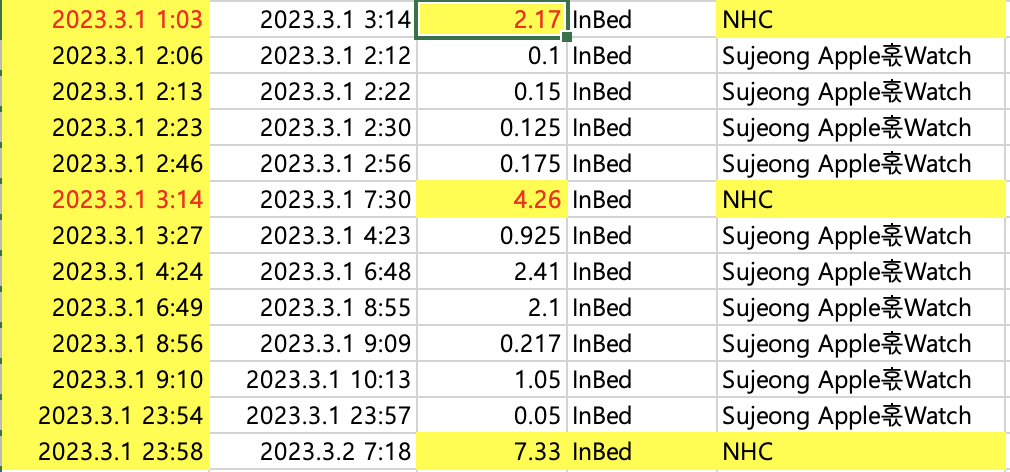

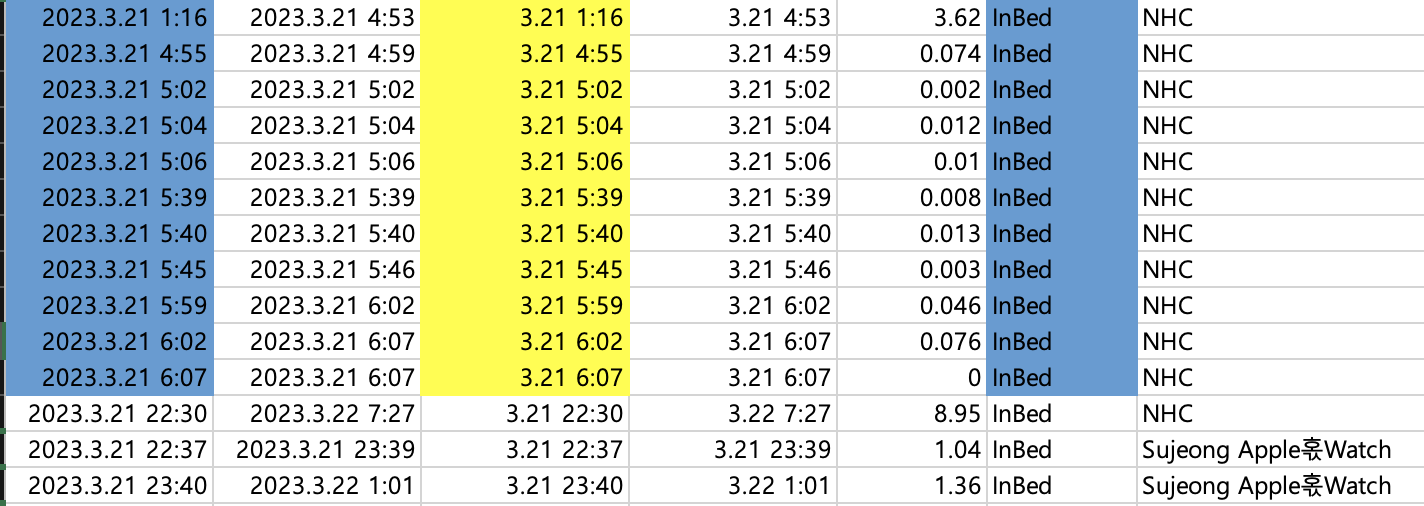

In [ ]:
# 하루 수면에 대한 정보가 담긴 InBed 데이터.
# [Value] == 'InBed'이고 ['Source']=='NHC'인 데이터 사용.
sleep_start = data[(data["Value"]=="InBed") & (data['Source']=='NHC')]

# Series to datetime
# 데이터 타입을 datetime으로 변경. 날짜와 시간 추출이 가능하도록 함.
sleep_start['Sl_Start'] = pd.to_datetime(sleep_start['Start'], format='%Y-%m-%d %H:%M:%S', errors='raise')
sleep_start.info()

In [ ]:
#slst = sleep_start

sleep_start['slst_month']   = sleep_start['Sl_Start'].dt.month
sleep_start['slst_day']   = sleep_start['Sl_Start'].dt.day          # 일(숫자)
sleep_start['slst_time']  = sleep_start['Sl_Start'].dt.time         # HH:MM:SS(문자)
sleep_start['slst_hour']  = sleep_start['Sl_Start'].dt.hour         # 시(숫자)
sleep_start['slst_minute'] = sleep_start['Sl_Start'].dt.minute       # 분(숫자)
sleep_start['slst_second'] = sleep_start['Sl_Start'].dt.second       # 초(숫자)

sleep_start.head()

# 데이터 전처리

In [34]:
data.head()

,Start,End,Duration (hr),Value,Source
0,2023-02-13 23:21:07,2023-02-14 08:47:48,9.440,InBed,NHC
1,2023-02-13 23:50:25,2023-02-14 00:07:25,0.283,Core,Sujeong의 Apple Watch
2,2023-02-14 00:07:25,2023-02-14 00:27:25,0.333,Deep,Sujeong의 Apple Watch
3,2023-02-14 00:27:25,2023-02-14 00:30:25,0.050,Core,Sujeong의 Apple Watch
4,2023-02-14 00:30:25,2023-02-14 00:38:25,0.133,Deep,Sujeong의 Apple Watch


In [35]:
data.tail()

,Start,End,Duration (hr),Value,Source
2950,2023-05-03 06:44:05,2023-05-03 07:09:05,0.417,REM,Sujeong의 Apple Watch
2951,2023-05-03 07:09:05,2023-05-03 07:29:05,0.333,Core,Sujeong의 Apple Watch
2952,2023-05-03 07:29:05,2023-05-03 07:30:05,0.017,Awake,Sujeong의 Apple Watch
2953,2023-05-03 07:30:05,2023-05-03 07:31:05,0.017,Core,Sujeong의 Apple Watch
2954,2023-05-03 07:30:05,2023-05-03 07:31:05,0.017,InBed,Sujeong의 Apple Watch


2023.02.13 ~ 2023.05.03 데이터

### [전처리 기준] 
  - 규칙적인 생활(2/20일 저녁, 2/21 KDT 교육 시작) 데이터 사용, 20일 이전 날짜 drop
  - ["Value"] != 'InBed'이고 ['Source'] != 'NHC'인 데이터 사용.

- 2/24 & 3/20 & 3/25 & 4/21 저녁 워치 착용하지 않고 수면 -> drop

# 이상치 확인
## 2/24 & 3/20 & 3/25 & 4/21 저녁 워치 착용 X

In [41]:
start_date = '2023-02-24 12:00:00'
end_date = '2023-02-25 12:00:00'
tmp = data[(data['Start']>=start_date) & (data['Start']<=end_date)]
tmp

,Start,End,Duration (hr),Value,Source
493,2023-02-25 01:40:05,2023-02-25 07:30:00,5.83,InBed,NHC


In [42]:
start_date = '2023-03-20 12:00:00'
end_date = '2023-03-21 12:00:00'
tmp = data[(data['Start']>=start_date) & (data['Start']<=end_date)]
tmp

,Start,End,Duration (hr),Value,Source
1410,2023-03-21 01:16:00,2023-03-21 04:53:26,3.620,InBed,NHC
1411,2023-03-21 04:55:06,2023-03-21 04:59:32,0.074,InBed,NHC
1412,2023-03-21 05:02:32,2023-03-21 05:02:38,0.002,InBed,NHC
1413,2023-03-21 05:04:03,2023-03-21 05:04:45,0.012,InBed,NHC
1414,2023-03-21 05:06:20,2023-03-21 05:06:55,0.010,InBed,NHC
1415,2023-03-21 05:39:26,2023-03-21 05:39:53,0.008,InBed,NHC
1416,2023-03-21 05:40:09,2023-03-21 05:40:57,0.013,InBed,NHC
1417,2023-03-21 05:45:57,2023-03-21 05:46:07,0.003,InBed,NHC
1418,2023-03-21 05:59:20,2023-03-21 06:02:06,0.046,InBed,NHC
1419,2023-03-21 06:02:26,2023-03-21 06:07:00,0.076,InBed,NHC


In [39]:
start_date = '2023-03-25 12:00:00'
end_date = '2023-03-26 12:00:00'
tmp = data[(data['Start']>=start_date) & (data['Start']<=end_date)]
tmp

,Start,End,Duration (hr),Value,Source
1572,2023-03-25 22:30:00,2023-03-26 07:30:12,9.0,InBed,NHC


In [45]:
start_date = '2023-04-21 12:00:00'
end_date = '2023-04-22 12:00:00'
tmp = data[(data['Start']>=start_date) & (data['Start']<=end_date)]
tmp

,Start,End,Duration (hr),Value,Source
2582,2023-04-22 00:40:57,2023-04-22 07:30:10,6.82,InBed,NHC


# 이상치 제거

In [129]:
start_date = '2023-02-20 12:00:00'
end_date = '2023-02-24 12:00:00'
a = data[(data['Start']>=start_date) & (data['Start']<=end_date)]

start_date = '2023-02-25 12:00:00'
end_date = '2023-03-20 12:00:00'
b = data[(data['Start']>=start_date) & (data['Start']<=end_date)]

start_date = '2023-03-21 12:00:00'
end_date = '2023-03-25 12:00:00'
c = data[(data['Start']>=start_date) & (data['Start']<=end_date)]

start_date = '2023-03-26 12:00:00'
end_date = '2023-04-21 12:00:00'
d = data[(data['Start']>=start_date) & (data['Start']<=end_date)]

start_date = '2023-04-22 12:00:00'
end_date = '2023-05-03 12:00:00'
e = data[(data['Start']>=start_date) & (data['Start']<=end_date)]

sj = pd.concat([a, b, c, d, e])
sj.head()

,Start,End,Duration (hr),Value,Source
296,2023-02-21 00:18:21,2023-02-21 06:00:23,5.700,InBed,NHC
297,2023-02-21 00:24:46,2023-02-21 00:52:16,0.458,Core,Sujeong의 Apple Watch
298,2023-02-21 00:24:46,2023-02-21 02:28:46,2.070,InBed,Sujeong의 Apple Watch
299,2023-02-21 00:52:16,2023-02-21 00:57:16,0.083,Deep,Sujeong의 Apple Watch
300,2023-02-21 00:57:16,2023-02-21 02:03:16,1.100,Core,Sujeong의 Apple Watch


In [133]:
# ["Value"] != 'InBed'인 데이터 사용.
sj = sj[sj['Value'] != "InBed"]
sj.head()

,Start,End,Duration (hr),Value,Source
297,2023-02-21 00:24:46,2023-02-21 00:52:16,0.458,Core,Sujeong의 Apple Watch
299,2023-02-21 00:52:16,2023-02-21 00:57:16,0.083,Deep,Sujeong의 Apple Watch
300,2023-02-21 00:57:16,2023-02-21 02:03:16,1.100,Core,Sujeong의 Apple Watch
301,2023-02-21 02:03:16,2023-02-21 02:28:46,0.425,Deep,Sujeong의 Apple Watch
302,2023-02-21 02:28:46,2023-02-21 02:29:16,0.008,Awake,Sujeong의 Apple Watch


In [136]:
# Series to datetime
# 데이터 타입을 datetime으로 변경한 "Sl_start" 열 추가. 날짜와 시간 추출이 가능하도록 함.
# datetime64[ns] 타입
sj['Sl_start'] = pd.to_datetime(sj['Start'], format='%Y-%m-%d %H:%M:%S', errors='raise')
sj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2039 entries, 297 to 2953
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Start          2039 non-null   object        
 1   End            2039 non-null   object        
 2   Duration (hr)  2039 non-null   float64       
 3   Value          2039 non-null   object        
 4   Source         2039 non-null   object        
 5   Sl_start       2039 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 111.5+ KB


# 주중 데이터셋 생성


  - 주중데이터만 이용
  - 주말은 나중에 따로

In [137]:
# 요일 정보를 담은 "weekday" 열 생성. 
# [int64]  타입
# Monday=0, Sunday=6.
import datetime

sj["weekday"] = sj['Sl_start'].dt.weekday
sj.head()

,Start,End,Duration (hr),Value,Source,Sl_start,weekday
297,2023-02-21 00:24:46,2023-02-21 00:52:16,0.458,Core,Sujeong의 Apple Watch,2023-02-21 00:24:46,1
299,2023-02-21 00:52:16,2023-02-21 00:57:16,0.083,Deep,Sujeong의 Apple Watch,2023-02-21 00:52:16,1
300,2023-02-21 00:57:16,2023-02-21 02:03:16,1.100,Core,Sujeong의 Apple Watch,2023-02-21 00:57:16,1
301,2023-02-21 02:03:16,2023-02-21 02:28:46,0.425,Deep,Sujeong의 Apple Watch,2023-02-21 02:03:16,1
302,2023-02-21 02:28:46,2023-02-21 02:29:16,0.008,Awake,Sujeong의 Apple Watch,2023-02-21 02:28:46,1


In [138]:
sj['weekday'].value_counts()

4    308
6    307
1    305
3    296
5    281
2    277
0    265
Name: weekday, dtype: int64

In [139]:
# 주중 데이터셋 'weekday' 생성
weekday = sj[sj['weekday'].between(0,4)]
weekday['weekday'].value_counts()

4    308
1    305
3    296
2    277
0    265
Name: weekday, dtype: int64

# 이진 분류 데이터셋으로 변경
### ["Value"] == 'Core' 면 1 아니면 0, 라벨링 달기

In [140]:
weekday['Value'].value_counts()

Core     674
Awake    323
REM      310
Deep     144
Name: Value, dtype: int64

In [141]:
# "Source" 열의 데이터를 레이블링 해줌.

weekday['Value']= weekday['Value'].replace('Deep',0)
weekday['Value']= weekday['Value'].replace('Core',1)
weekday['Value']= weekday['Value'].replace('REM',0)
weekday['Value']= weekday['Value'].replace('Awake',0)

weekday['Value'].value_counts()

<ipython-input-141-3323a29a578b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekday['Value']= weekday['Value'].replace('Deep',0)
<ipython-input-141-3323a29a578b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekday['Value']= weekday['Value'].replace('Core',1)
<ipython-input-141-3323a29a578b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

0    777
1    674
Name: Value, dtype: int64

# 출발점: 수면 시작시간의 평균/ 끝점: 기상시간의 평균 구하기

## 날짜별로 데이터 저장하고 불러와서 출발점과 끝점을 구하고자 함.
## 주말과 주중은 우선 만들고 수작업으로 분리함.(ㅠ)

In [143]:
import os
import datetime

# 이름 저장을 위해 월별로 구분함
start_date = '2023-02-20 12:00:00'
end_date = '2023-02-24 12:00:00'
start_date = pd.to_datetime(start_date, format='%Y-%m-%d %H:%M:%S', errors='raise')
end_date = pd.to_datetime(end_date, format='%Y-%m-%d %H:%M:%S', errors='raise')

# 2월 데이터를 tmp로 저장.
# "NHC"와 'InBed'를 모두 제외한 데이터.
tmp = sj[(sj['Sl_start']>=start_date) & (sj['Sl_start']<=end_date)]

# 2월 21일부터 시작.
d = 21  # 21일
date_diff = end_date - start_date   # 날짜 차이만큼 반복해서 데이터를 저장할 것이기 때문.
rep = date_diff.days   # 반복할 횟수(날)만 추출
file_path = "/content/drive/MyDrive/KDT_project/HACKATHON/data/day_split"   # 데이터를 저장할 경로
os.chdir(file_path)

loop_date_1 = start_date  # 하루 수면패턴 추출을 위한 시작 date

for i in range(rep):
  days = datetime.timedelta(days=1)
  loop_date_2 = loop_date_1 + days     # 하루 수면패턴 추출을 위한 끝 date
  loop = tmp[(tmp['Sl_start']>=loop_date_1) & (tmp['Sl_start']<=loop_date_2)]  # 하루 수면패턴 추출.

  dst = "Feb_" + str(d) + '.csv'
  loop.to_csv(dst)

  loop_date_1 = loop_date_2
  d += 1

In [144]:
import os
import datetime

# 이름 저장을 위해 월별로 구분함
start_date = '2023-02-25 12:00:00'
end_date = '2023-02-28 12:00:00'
start_date = pd.to_datetime(start_date, format='%Y-%m-%d %H:%M:%S', errors='raise')
end_date = pd.to_datetime(end_date, format='%Y-%m-%d %H:%M:%S', errors='raise')

tmp = sj[(sj['Sl_start']>=start_date) & (sj['Sl_start']<=end_date)]

# 2월 26일부터 시작.
d = 26  # 26일
date_diff = end_date - start_date   # 날짜 차이만큼 반복해서 데이터를 저장할 것이기 때문.
rep = date_diff.days   # 반복할 횟수(날)만 추출
file_path = "/content/drive/MyDrive/KDT_project/HACKATHON/data/day_split"   # 데이터를 저장할 경로
os.chdir(file_path)

loop_date_1 = start_date  # 하루 수면패턴 추출을 위한 시작 date

for i in range(rep):
  days = datetime.timedelta(days=1)
  loop_date_2 = loop_date_1 + days     # 하루 수면패턴 추출을 위한 끝 date
  loop = tmp[(tmp['Sl_start']>=loop_date_1) & (tmp['Sl_start']<=loop_date_2)]  # 하루 수면패턴 추출.

  dst = "Feb_" + str(d) + '.csv'
  loop.to_csv(dst)

  loop_date_1 = loop_date_2
  d += 1

In [145]:
import os
import datetime

# 이름 저장을 위해 월별로 구분함
start_date = '2023-02-28 12:00:00'
end_date = '2023-03-20 12:00:00'
start_date = pd.to_datetime(start_date, format='%Y-%m-%d %H:%M:%S', errors='raise')
end_date = pd.to_datetime(end_date, format='%Y-%m-%d %H:%M:%S', errors='raise')

tmp = sj[(sj['Sl_start']>=start_date) & (sj['Sl_start']<=end_date)]

# 3월 1일부터 시작.
d = 1
date_diff = end_date - start_date   # 날짜 차이만큼 반복해서 데이터를 저장할 것이기 때문.
rep = date_diff.days   # 반복할 횟수(날)만 추출
file_path = "/content/drive/MyDrive/KDT_project/HACKATHON/data/day_split"   # 데이터를 저장할 경로
os.chdir(file_path)

loop_date_1 = start_date  # 하루 수면패턴 추출을 위한 시작 date

for i in range(rep):
  days = datetime.timedelta(days=1)
  loop_date_2 = loop_date_1 + days     # 하루 수면패턴 추출을 위한 끝 date
  loop = tmp[(tmp['Sl_start']>=loop_date_1) & (tmp['Sl_start']<=loop_date_2)]  # 하루 수면패턴 추출.

  dst = "March_" + str(d) + '.csv'
  loop.to_csv(dst)

  loop_date_1 = loop_date_2
  d += 1

In [146]:
import os
import datetime

# 이름 저장을 위해 월별로 구분함
start_date = '2023-03-21 12:00:00'
end_date = '2023-03-25 12:00:00'
start_date = pd.to_datetime(start_date, format='%Y-%m-%d %H:%M:%S', errors='raise')
end_date = pd.to_datetime(end_date, format='%Y-%m-%d %H:%M:%S', errors='raise')

tmp = sj[(sj['Sl_start']>=start_date) & (sj['Sl_start']<=end_date)]

# 3월 22일부터 시작.
d = 22
date_diff = end_date - start_date   # 날짜 차이만큼 반복해서 데이터를 저장할 것이기 때문.
rep = date_diff.days   # 반복할 횟수(날)만 추출
file_path = "/content/drive/MyDrive/KDT_project/HACKATHON/data/day_split"   # 데이터를 저장할 경로
os.chdir(file_path)

loop_date_1 = start_date  # 하루 수면패턴 추출을 위한 시작 date

for i in range(rep):
  days = datetime.timedelta(days=1)
  loop_date_2 = loop_date_1 + days     # 하루 수면패턴 추출을 위한 끝 date
  loop = tmp[(tmp['Sl_start']>=loop_date_1) & (tmp['Sl_start']<=loop_date_2)]  # 하루 수면패턴 추출.

  dst = "March_" + str(d) + '.csv'
  loop.to_csv(dst)

  loop_date_1 = loop_date_2
  d += 1

In [147]:
import os
import datetime

# 이름 저장을 위해 월별로 구분함
start_date = '2023-03-26 12:00:00'
end_date = '2023-03-31 12:00:00'
start_date = pd.to_datetime(start_date, format='%Y-%m-%d %H:%M:%S', errors='raise')
end_date = pd.to_datetime(end_date, format='%Y-%m-%d %H:%M:%S', errors='raise')

tmp = sj[(sj['Sl_start']>=start_date) & (sj['Sl_start']<=end_date)]

# 3월 27일부터 시작.
d = 27
date_diff = end_date - start_date   # 날짜 차이만큼 반복해서 데이터를 저장할 것이기 때문.
rep = date_diff.days   # 반복할 횟수(날)만 추출
file_path = "/content/drive/MyDrive/KDT_project/HACKATHON/data/day_split"   # 데이터를 저장할 경로
os.chdir(file_path)

loop_date_1 = start_date  # 하루 수면패턴 추출을 위한 시작 date

for i in range(rep):
  days = datetime.timedelta(days=1)
  loop_date_2 = loop_date_1 + days     # 하루 수면패턴 추출을 위한 끝 date
  loop = tmp[(tmp['Sl_start']>=loop_date_1) & (tmp['Sl_start']<=loop_date_2)]  # 하루 수면패턴 추출.

  dst = "March_" + str(d) + '.csv'
  loop.to_csv(dst)

  loop_date_1 = loop_date_2
  d += 1

In [150]:
import os
import datetime

# 이름 저장을 위해 월별로 구분함
start_date = '2023-03-31 12:00:00'
end_date = '2023-04-21 12:00:00'
start_date = pd.to_datetime(start_date, format='%Y-%m-%d %H:%M:%S', errors='raise')
end_date = pd.to_datetime(end_date, format='%Y-%m-%d %H:%M:%S', errors='raise')

tmp = sj[(sj['Sl_start']>=start_date) & (sj['Sl_start']<=end_date)]

# 4월 1일부터 시작.
d = 1
date_diff = end_date - start_date   # 날짜 차이만큼 반복해서 데이터를 저장할 것이기 때문.
rep = date_diff.days   # 반복할 횟수(날)만 추출
file_path = "/content/drive/MyDrive/KDT_project/HACKATHON/data/day_split"   # 데이터를 저장할 경로
os.chdir(file_path)

loop_date_1 = start_date  # 하루 수면패턴 추출을 위한 시작 date

for i in range(rep):
  days = datetime.timedelta(days=1)
  loop_date_2 = loop_date_1 + days     # 하루 수면패턴 추출을 위한 끝 date
  loop = tmp[(tmp['Sl_start']>=loop_date_1) & (tmp['Sl_start']<=loop_date_2)]  # 하루 수면패턴 추출.

  dst = "April_" + str(d) + '.csv'
  loop.to_csv(dst)

  loop_date_1 = loop_date_2
  d += 1

In [151]:
import os
import datetime

# 이름 저장을 위해 월별로 구분함
start_date = '2023-04-22 12:00:00'
end_date = '2023-04-30 12:00:00'
start_date = pd.to_datetime(start_date, format='%Y-%m-%d %H:%M:%S', errors='raise')
end_date = pd.to_datetime(end_date, format='%Y-%m-%d %H:%M:%S', errors='raise')

tmp = sj[(sj['Sl_start']>=start_date) & (sj['Sl_start']<=end_date)]

# 4월 23일부터 시작.
d = 23
date_diff = end_date - start_date   # 날짜 차이만큼 반복해서 데이터를 저장할 것이기 때문.
rep = date_diff.days   # 반복할 횟수(날)만 추출
file_path = "/content/drive/MyDrive/KDT_project/HACKATHON/data/day_split"   # 데이터를 저장할 경로
os.chdir(file_path)

loop_date_1 = start_date  # 하루 수면패턴 추출을 위한 시작 date

for i in range(rep):
  days = datetime.timedelta(days=1)
  loop_date_2 = loop_date_1 + days     # 하루 수면패턴 추출을 위한 끝 date
  loop = tmp[(tmp['Sl_start']>=loop_date_1) & (tmp['Sl_start']<=loop_date_2)]  # 하루 수면패턴 추출.

  dst = "April_" + str(d) + '.csv'
  loop.to_csv(dst)

  loop_date_1 = loop_date_2
  d += 1

In [152]:
import os
import datetime

# 이름 저장을 위해 월별로 구분함
start_date = '2023-04-30 12:00:00'
end_date = '2023-05-03 12:00:00'
start_date = pd.to_datetime(start_date, format='%Y-%m-%d %H:%M:%S', errors='raise')
end_date = pd.to_datetime(end_date, format='%Y-%m-%d %H:%M:%S', errors='raise')

tmp = sj[(sj['Sl_start']>=start_date) & (sj['Sl_start']<=end_date)]

# 5월 1일부터 시작.
d = 1
date_diff = end_date - start_date   # 날짜 차이만큼 반복해서 데이터를 저장할 것이기 때문.
rep = date_diff.days   # 반복할 횟수(날)만 추출
file_path = "/content/drive/MyDrive/KDT_project/HACKATHON/data/day_split"   # 데이터를 저장할 경로
os.chdir(file_path)

loop_date_1 = start_date  # 하루 수면패턴 추출을 위한 시작 date

for i in range(rep):
  days = datetime.timedelta(days=1)
  loop_date_2 = loop_date_1 + days     # 하루 수면패턴 추출을 위한 끝 date
  loop = tmp[(tmp['Sl_start']>=loop_date_1) & (tmp['Sl_start']<=loop_date_2)]  # 하루 수면패턴 추출.

  dst = "May_" + str(d) + '.csv'
  loop.to_csv(dst)

  loop_date_1 = loop_date_2
  d += 1

## 주중 데이터 불러오기

In [182]:
## 해당 경로에 있는 .csv 파일명 리스트 가져오기

import os

path = '/content/drive/MyDrive/KDT_project/HACKATHON/data/day_split_weekday'
file_list = os.listdir(path)
file_name = [file for file in file_list if file.endswith('.csv')] ## 파일명 끝이 .csv인 경우

In [183]:
cd /content/drive/MyDrive/KDT_project/HACKATHON/data/day_split_weekday

/content/drive/MyDrive/KDT_project/HACKATHON/data/day_split_weekday


In [189]:
data_weekday = pd.DataFrame()

for files in file_name:
    df= pd.read_csv(files)
    data_weekday = pd.concat([data_weekday, df])

In [190]:
data_weekday

,Unnamed: 0,Start,End,Duration (hr),Value,Source,Sl_start,weekday
0,297,2023-02-21 00:24:46,2023-02-21 00:52:16,0.458,Core,Sujeong의 Apple Watch,2023-02-21 00:24:46,1
1,299,2023-02-21 00:52:16,2023-02-21 00:57:16,0.083,Deep,Sujeong의 Apple Watch,2023-02-21 00:52:16,1
2,300,2023-02-21 00:57:16,2023-02-21 02:03:16,1.100,Core,Sujeong의 Apple Watch,2023-02-21 00:57:16,1
3,301,2023-02-21 02:03:16,2023-02-21 02:28:46,0.425,Deep,Sujeong의 Apple Watch,2023-02-21 02:03:16,1
4,302,2023-02-21 02:28:46,2023-02-21 02:29:16,0.008,Awake,Sujeong의 Apple Watch,2023-02-21 02:28:46,1
...,...,...,...,...,...,...,...,...
16,2948,2023-05-03 06:16:05,2023-05-03 06:44:05,0.467,Core,Sujeong의 Apple Watch,2023-05-03 06:16:05,2
17,2950,2023-05-03 06:44:05,2023-05-03 07:09:05,0.417,REM,Sujeong의 Apple Watch,2023-05-03 06:44:05,2
18,2951,2023-05-03 07:09:05,2023-05-03 07:29:05,0.333,Core,Sujeong의 Apple Watch,2023-05-03 07:09:05,2
19,2952,2023-05-03 07:29:05,2023-05-03 07:30:05,0.017,Awake,Sujeong의 Apple Watch,2023-05-03 07:29:05,2


In [191]:
data_weekday = data_weekday.drop('Unnamed: 0', axis=1)
data_weekday   

,Start,End,Duration (hr),Value,Source,Sl_start,weekday
0,2023-02-21 00:24:46,2023-02-21 00:52:16,0.458,Core,Sujeong의 Apple Watch,2023-02-21 00:24:46,1
1,2023-02-21 00:52:16,2023-02-21 00:57:16,0.083,Deep,Sujeong의 Apple Watch,2023-02-21 00:52:16,1
2,2023-02-21 00:57:16,2023-02-21 02:03:16,1.100,Core,Sujeong의 Apple Watch,2023-02-21 00:57:16,1
3,2023-02-21 02:03:16,2023-02-21 02:28:46,0.425,Deep,Sujeong의 Apple Watch,2023-02-21 02:03:16,1
4,2023-02-21 02:28:46,2023-02-21 02:29:16,0.008,Awake,Sujeong의 Apple Watch,2023-02-21 02:28:46,1
...,...,...,...,...,...,...,...
16,2023-05-03 06:16:05,2023-05-03 06:44:05,0.467,Core,Sujeong의 Apple Watch,2023-05-03 06:16:05,2
17,2023-05-03 06:44:05,2023-05-03 07:09:05,0.417,REM,Sujeong의 Apple Watch,2023-05-03 06:44:05,2
18,2023-05-03 07:09:05,2023-05-03 07:29:05,0.333,Core,Sujeong의 Apple Watch,2023-05-03 07:09:05,2
19,2023-05-03 07:29:05,2023-05-03 07:30:05,0.017,Awake,Sujeong의 Apple Watch,2023-05-03 07:29:05,2


In [197]:
# 출발점(잠드는 시간) 데이터셋 생성 "weekday_start"
weekday_start = data_weekday.loc[0]
weekday_start

,Start,End,Duration (hr),Value,Source,Sl_start,weekday
0,2023-02-21 00:24:46,2023-02-21 00:52:16,0.458,Core,Sujeong의 Apple Watch,2023-02-21 00:24:46,1
0,2023-02-22 00:29:17,2023-02-22 00:47:17,0.300,Core,Sujeong의 Apple Watch,2023-02-22 00:29:17,2
0,2023-02-23 00:19:53,2023-02-23 00:36:23,0.275,Core,Sujeong의 Apple Watch,2023-02-23 00:19:53,3
0,2023-02-23 22:54:10,2023-02-23 22:58:40,0.075,Core,Sujeong의 Apple Watch,2023-02-23 22:54:10,3
0,2023-02-26 23:36:12,2023-02-26 23:57:42,0.358,Core,Sujeong의 Apple Watch,2023-02-26 23:36:12,6
0,2023-02-27 23:59:19,2023-02-28 00:22:49,0.392,Core,Sujeong의 Apple Watch,2023-02-27 23:59:19,0
0,2023-03-01 02:06:14,2023-03-01 02:12:14,0.100,Core,Sujeong의 Apple Watch,2023-03-01 02:06:14,2
0,2023-03-01 23:54:17,2023-03-01 23:57:17,0.050,Core,Sujeong의 Apple Watch,2023-03-01 23:54:17,2
0,2023-03-03 00:13:13,2023-03-03 00:16:43,0.058,Core,Sujeong의 Apple Watch,2023-03-03 00:13:13,4
0,2023-03-05 23:29:05,2023-03-05 23:30:35,0.025,Core,Sujeong의 Apple Watch,2023-03-05 23:29:05,6


In [200]:
weekday.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 297 to 2953
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Start          1451 non-null   object        
 1   End            1451 non-null   object        
 2   Duration (hr)  1451 non-null   float64       
 3   Value          1451 non-null   int64         
 4   Source         1451 non-null   object        
 5   Sl_start       1451 non-null   datetime64[ns]
 6   weekday        1451 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 90.7+ KB


In [204]:
weekday_start['Sl_start'] = pd.to_datetime(weekday_start['Sl_start'], format='%Y-%m-%d %H:%M:%S', errors='raise')
weekday_start['slst_time']  = weekday_start['Sl_start'].dt.time         # HH:MM:SS(문자)
weekday_start.head()

<ipython-input-204-a734cdf81876>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekday_start['slst_time']  = weekday_start['Sl_start'].dt.time         # HH:MM:SS(문자)


,Start,End,Duration (hr),Value,Source,Sl_start,weekday,slst_time
0,2023-02-21 00:24:46,2023-02-21 00:52:16,0.458,Core,Sujeong의 Apple Watch,2023-02-21 00:24:46,1,00:24:46
0,2023-02-22 00:29:17,2023-02-22 00:47:17,0.300,Core,Sujeong의 Apple Watch,2023-02-22 00:29:17,2,00:29:17
0,2023-02-23 00:19:53,2023-02-23 00:36:23,0.275,Core,Sujeong의 Apple Watch,2023-02-23 00:19:53,3,00:19:53
0,2023-02-23 22:54:10,2023-02-23 22:58:40,0.075,Core,Sujeong의 Apple Watch,2023-02-23 22:54:10,3,22:54:10
0,2023-02-26 23:36:12,2023-02-26 23:57:42,0.358,Core,Sujeong의 Apple Watch,2023-02-26 23:36:12,6,23:36:12


In [207]:
tmp = weekday_start.set_index('Sl_start')
tmp.head()

,Start,End,Duration (hr),Value,Source,weekday,slst_time
Sl_start,,,,,,,
2023-02-21 00:24:46,2023-02-21 00:24:46,2023-02-21 00:52:16,0.458,Core,Sujeong의 Apple Watch,1,00:24:46
2023-02-22 00:29:17,2023-02-22 00:29:17,2023-02-22 00:47:17,0.300,Core,Sujeong의 Apple Watch,2,00:29:17
2023-02-23 00:19:53,2023-02-23 00:19:53,2023-02-23 00:36:23,0.275,Core,Sujeong의 Apple Watch,3,00:19:53
2023-02-23 22:54:10,2023-02-23 22:54:10,2023-02-23 22:58:40,0.075,Core,Sujeong의 Apple Watch,3,22:54:10
2023-02-26 23:36:12,2023-02-26 23:36:12,2023-02-26 23:57:42,0.358,Core,Sujeong의 Apple Watch,6,23:36:12


# ! 시간 평균 계산하는 방법 이어서 하기

# 시간 별로 평균 내기
# resample

In [85]:
tmp = weekday.set_index('Sl_start')
tmp.head()

,Start,End,Duration (hr),Value,Source,weekday
Sl_start,,,,,,
2023-02-21 00:24:46,2023-02-21 00:24:46,2023-02-21 00:52:16,0.458,1,Sujeong의 Apple Watch,1
2023-02-21 00:52:16,2023-02-21 00:52:16,2023-02-21 00:57:16,0.083,0,Sujeong의 Apple Watch,1
2023-02-21 00:57:16,2023-02-21 00:57:16,2023-02-21 02:03:16,1.100,1,Sujeong의 Apple Watch,1
2023-02-21 02:03:16,2023-02-21 02:03:16,2023-02-21 02:28:46,0.425,0,Sujeong의 Apple Watch,1
2023-02-21 02:28:46,2023-02-21 02:28:46,2023-02-21 02:29:16,0.008,0,Sujeong의 Apple Watch,1


In [86]:
from datetime import datetime
newDf = tmp.resample(rule='H').mean()

<ipython-input-86-de9cfc73883a>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  newDf = tmp.resample(rule='H').mean()


In [92]:
newDf.head(50)


# 2023-02-21 00:57:16	2023-02-21 02:03:16 의 경우 01:00:00이 NaN이 되는 치명적인 문제 발생..

,Duration (hr),Value,weekday
Sl_start,,,
2023-02-21 00:00:00,0.547000,0.666667,1.0
2023-02-21 01:00:00,NaN,NaN,NaN
2023-02-21 02:00:00,0.297750,0.250000,1.0
2023-02-21 03:00:00,0.538500,0.500000,1.0
2023-02-21 04:00:00,0.137000,0.400000,1.0
2023-02-21 05:00:00,0.088000,0.454545,1.0
2023-02-21 06:00:00,NaN,NaN,NaN
2023-02-21 07:00:00,NaN,NaN,NaN
2023-02-21 08:00:00,NaN,NaN,NaN


In [88]:
from datetime import datetime
newDf_D = tmp.resample(rule='D').mean()
newDf_D.head()

<ipython-input-88-f09ed899303a>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  newDf_D = tmp.resample(rule='D').mean()


,Duration (hr),Value,weekday
Sl_start,,,
2023-02-21,0.222480,0.440000,1.0
2023-02-22,0.210235,0.441176,2.0
2023-02-23,0.217316,0.473684,3.0
2023-02-24,0.151694,0.448980,4.0
2023-02-25,NaN,NaN,NaN
